Домашнее задание номер 4 по курсу "Методы визуализации данных".

Выполнил Лазичный Иван Александрович, группа М05-012б

Реализован алгоритм t-SNE для визуализации многомерных данных. 

In [16]:
import numpy as np
from sklearn.datasets import load_digits
from sklearn.metrics import pairwise_distances
import tqdm
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
palette = sns.color_palette("bright", 10)

Загрузим и нормируем данные из sklearn, в качестве примера будем работать с цифрами, нарисованными от руки

In [17]:
X, y = load_digits(return_X_y=True)
X = X/np.max(X)
print(X.shape)

(1797, 64)


Функции для поиска cигмы, которая будет различной для каждой точки. Она выбирается так, чтобы точки в областях с большей плотностью имели меньшую дисперсию. Для этого используется оценка перплексии:

In [18]:
def perpCalc(D, b=1.0):
    prob = np.exp(-D.copy() * b)
    sumP = sum(prob)
    H = np.log(sumP) + b * np.sum(D * prob) / sumP
    prob = prob / sumP
    return H, prob

#Сигма определяется для каждой пары X_i и X_j при помощи алгоритма бинарного поиска.
def joinProb(dist, tol=1e-5, perplexity=30.0):

    (n, d) = dist.shape
    gamma = np.ones((n, 1))
    logPer = np.log(perplexity)
    prob = np.zeros((n, n))

    for i in range(n):

        dist_i = dist[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))]
        (H, newP) = perpCalc(dist_i, gamma[i])
        gamma_max = np.inf
        gamma_min = -np.inf
        h_diff = H - logPer
        iters = 0
        while iters < 50 and np.abs(h_diff) > tol:
            if h_diff <= 0:
                gamma_max = gamma[i].copy()
                if gamma_min == np.inf or gamma_min == -np.inf:
                    gamma[i] = gamma[i] / 2.
                else:
                    gamma[i] = (gamma[i] + gamma_min) / 2.

            else:
                gamma_min = gamma[i].copy()
                if gamma_max == np.inf or gamma_max == -np.inf:
                    gamma[i] = gamma[i] * 2.
                else:
                    gamma[i] = (gamma[i] + gamma_max) / 2.

            (H, newP) = perpCalc(dist_i, gamma[i])
            h_diff = H - logPer
            iters += 1

        prob[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))] = newP

    return prob

Ниже реализована функция, которая выполняет основной алгоритм. Здесь мы используем «раннее гиперусиление» («early exaggeration»). Заключается оно в умножении в начале оптимизации всех p_ij на некоторое целое число, например на 4. Смысл в том, чтобы для больших p_ij получить бόльшие q_ij. Это позволит для кластеров в исходных данных получить плотные и широко разнесенные кластеры в пространстве отображения.


In [19]:
def fit_pridict(X, new_dims, initial_dims, perplexity):
    distances = pairwise_distances(X, metric='euclidean', squared=True)
    (n, d) = X.shape
    iters = 1000
    
    Y = np.random.randn(n, new_dims)
    grad = np.zeros((n, new_dims))
    gains = np.ones((n, new_dims))
    initial_moment = 0.5
    final_moment = 0.8
    eta = 500
    min_gain = 0.01
    #вычислим распределение: 
    P = joinProb(distances, 1e-5, perplexity)
    P = P + np.transpose(P)
    P = P / np.sum(P)
    # early exaggeration
    P = P * 4.									
    P = np.maximum(P, 1e-12)
    Y_t = np.zeros((n, new_dims))

    for iter in tqdm.tqdm(range(iters)):
        num = pairwise_distances(Y, metric='euclidean', squared=True)
        num = 1/(1 + num)
        num[range(n), range(n)] = 0.
        Q = num / np.sum(num)
        Q = np.maximum(Q, 1e-12)

        PQ = P - Q
        grad = getGrad(PQ, num, Y, new_dims, n)

        #Если градиент не меняет свой знак на очередной итерации, шаг увеличивается линейно (к коэффициенту усиления добавляется 0.2),
        #если знак меняется — то уменьшается экспоненциально (коэффициент умножается на 0.8). С учетом того, что градиент у нас обратного знака:

        if iter < 20:
            momentum = initial_moment
        else:
            momentum = final_moment
        gains = (gains + 0.2) * (np.sign(grad) != np.sign(Y_t)) + \
                (gains * 0.8) * (np.sign(grad) == np.sign(Y_t))
        gains[gains < min_gain] = min_gain
        Y_t = momentum * Y_t - eta * (gains * grad)
        Y = Y + Y_t
        Y = Y - np.tile(np.mean(Y, 0), (n, 1))

        if (iter + 1) % 100 == 0:
            error = np.sum(P * np.log(P / Q))
            print("Iteration %d: error is %f" % (iter + 1, error))

        if iter == 100:
            P = P / 4.

    return Y

In [20]:
def getDistr(Y):
  num = pairwise_distances(Y, metric='euclidean', squared=True)
  num = 1/(1 + num)
  num[range(n), range(n)] = 0.
  q = num / np.sum(num)
  q = np.maximum(Q, 1e-12)        
  return q, num

In [21]:
def getGrad(PQ, num, Y, no_dims, n):
  dY = np.zeros((n, no_dims))
  for i in range(n):
    expr1 = PQ[:, i] * num[:, i]
    expr2 = Y[i, :] - Y
    expr2[:,0] = expr2[:,0]*expr1
    expr2[:,1] = expr2[:,1]*expr1
    dY[i, :] = np.sum(expr2, 0)
  return(dY)

In [22]:
Y = fit_pridict(X, 2, 50, 20.0)


 10%|█         | 100/1000 [00:23<04:04,  3.68it/s]

Iteration 100: error is 13.707605



 20%|██        | 200/1000 [00:48<03:39,  3.64it/s]

Iteration 200: error is 1.000160



 30%|███       | 300/1000 [01:12<03:09,  3.70it/s]

Iteration 300: error is 0.845683



 40%|████      | 400/1000 [01:36<02:42,  3.69it/s]

Iteration 400: error is 0.793981



 50%|█████     | 500/1000 [02:00<02:14,  3.71it/s]

Iteration 500: error is 0.768789



 60%|██████    | 600/1000 [02:25<01:50,  3.62it/s]

Iteration 600: error is 0.753981



 70%|███████   | 700/1000 [02:49<01:22,  3.65it/s]

Iteration 700: error is 0.744233



 80%|████████  | 800/1000 [03:13<00:54,  3.65it/s]

Iteration 800: error is 0.737351



 90%|█████████ | 900/1000 [03:37<00:27,  3.60it/s]

Iteration 900: error is 0.732191



100%|██████████| 1000/1000 [04:02<00:00,  4.13it/s]

Iteration 1000: error is 0.728200


Визуализируем данные:

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


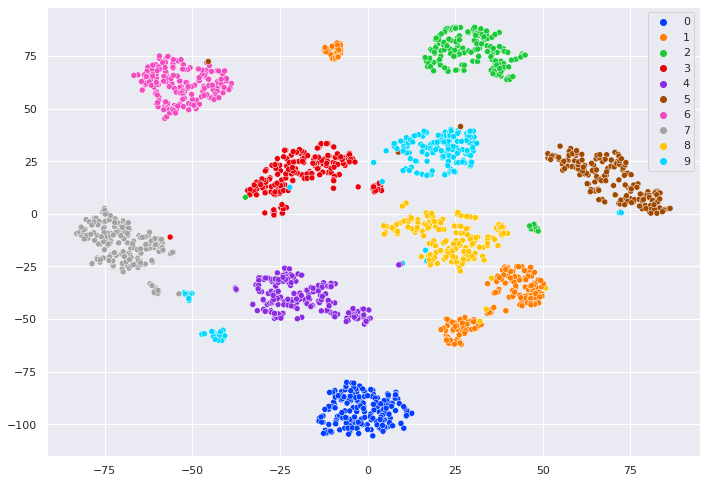

In [23]:
sns.scatterplot(Y[:,0], Y[:,1], hue=y, legend='full', palette=palette)